Multiclass classification C)

mRNA localization using multiclass classification <br> 
Classes: cytoplasm, endoplasmic reticulum, mitochondira and nucleus <br>
Basic model with: <br> 
<br>
a) Method 6: no feature selection and class weights accounted for <br>
b) Method 7: with feature importance-based feature selection (SHAP), w/ threshold > 0  and class weights accounted for<br>

In [1]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from catboost import Pool
import shap


In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, f1_score, auc, classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px


In [3]:
#Data initialization

all_train = pd.read_csv("../../Data/InputData/all_loc_train.csv")
all_test = pd.read_csv("../../Data/InputData/all_loc_test.csv")

print("TRAINING SET SHAPE:", all_train.shape)
print("TESTING SET SHAPE:", all_test.shape)
# all_train.info()
all_train.head(1122)

TRAINING SET SHAPE: (2040, 1026)
TESTING SET SHAPE: (510, 1026)


,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_403#10320|0|training,0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,mRNALoc_4404#20399|0|training,0,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,mRNALoc_3392#17196|0|training,0,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,mRNALoc_3095#162989|0|training,0,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,mRNALoc_1488#117177|0|training,0,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,mRNALoc_4037#1951|1|training,1,0.001170,0.000334,0.000334,0.000334,0.000418,0.000167,0.000000,0.000501,...,0.000752,0.000501,0.000919,0.000668,0.000752,0.001170,0.000501,0.000418,0.001086,0.000835
1118,mRNALoc_17428#8029|1|training,1,0.002263,0.001006,0.001090,0.001341,0.001760,0.000922,0.000168,0.001593,...,0.000168,0.001174,0.002012,0.001090,0.000922,0.001760,0.001006,0.001425,0.001257,0.001760
1119,mRNALoc_11450#5362|1|training,1,0.003929,0.001135,0.001572,0.000960,0.001135,0.000786,0.000175,0.000699,...,0.000175,0.001572,0.001746,0.000960,0.001222,0.001222,0.000611,0.000873,0.001484,0.001310
1120,mRNALoc_18600#853213|2|training,2,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


<Axes: >

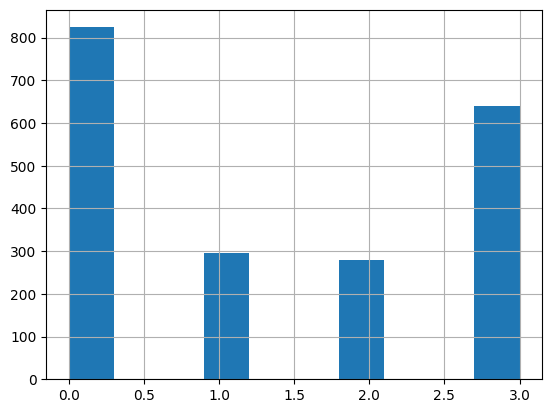

In [4]:
# Remove name/symbol column and separate labels and variables from training set to create X and y sets
# Check distribution of training set

noname_train = all_train.drop("#", axis="columns")

X_train = noname_train.drop("label", axis="columns")
y_train = noname_train["label"]

y_train.hist()

In [5]:
y_train.value_counts()

label
0    824
3    640
1    296
2    280
Name: count, dtype: int64

<Axes: >

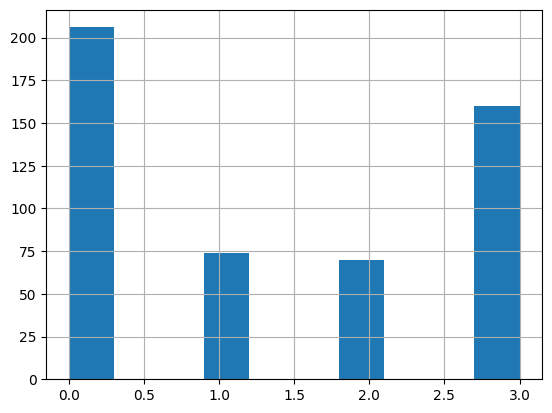

In [6]:
# Remove name/symbol column and separate labels and variables from testing set to create X and y sets
# Check distribution of testing set

noname_test = all_test.drop("#", axis="columns")

X_test = noname_test.drop("label", axis="columns")
y_test = noname_test["label"]

y_test.hist()

In [7]:
# Create data pool for feature importance/selection for full set

ALL_feature_names = list(X_train.columns)
print("Number of features:", len(ALL_feature_names))

ALL_train_pool = Pool(X_train, y_train, feature_names = ALL_feature_names)

ALL_test_pool = Pool(X_test, y_test)

print("Data pool created for full set")


Number of features: 1024
Data pool created for full set


    Method 6: Basic model with class imbalance taken into account (but without feature importance/selection/hyperparameter tuning)

In [8]:
#Create and fit CatBoost model

model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")
model.fit(ALL_train_pool)

Learning rate set to 0.082057
0:	learn: 1.3341220	total: 652ms	remaining: 10m 51s
1:	learn: 1.2894640	total: 981ms	remaining: 8m 9s
2:	learn: 1.2511612	total: 1.28s	remaining: 7m 6s
3:	learn: 1.2148625	total: 1.58s	remaining: 6m 34s
4:	learn: 1.1814561	total: 1.86s	remaining: 6m 9s
5:	learn: 1.1504487	total: 2.15s	remaining: 5m 55s
6:	learn: 1.1223728	total: 2.45s	remaining: 5m 48s
7:	learn: 1.0963222	total: 2.74s	remaining: 5m 39s
8:	learn: 1.0728770	total: 3.02s	remaining: 5m 33s
9:	learn: 1.0500412	total: 3.32s	remaining: 5m 29s
10:	learn: 1.0303628	total: 3.61s	remaining: 5m 24s
11:	learn: 1.0112057	total: 3.91s	remaining: 5m 22s
12:	learn: 0.9945192	total: 4.19s	remaining: 5m 18s
13:	learn: 0.9784730	total: 4.48s	remaining: 5m 15s
14:	learn: 0.9610337	total: 4.77s	remaining: 5m 13s
15:	learn: 0.9445322	total: 5.08s	remaining: 5m 12s
16:	learn: 0.9299192	total: 5.37s	remaining: 5m 10s
17:	learn: 0.9183477	total: 5.69s	remaining: 5m 10s
18:	learn: 0.9063680	total: 6s	remaining: 5m 9

In [9]:
#Get multiclass classification prediction using X_test
y_test_pred = model.predict(X_test)

# Prediction probability
y_test_prob = model.predict_proba(X_test)

In [24]:
# Calculate accuracy scores and get classification report

print("Model 6: Basic model w/ class imbalance accounted for - Multiclass")

ALL_cr = classification_report(y_test, y_test_pred, digits=3)
print(ALL_cr)

print("Accuracy score: ", accuracy_score(y_test, y_test_pred))

print("\nROC AUC score : ", roc_auc_score(y_test, y_test_prob, multi_class='ovr'))

ALL_f1 = f1_score(y_test, y_test_pred, average="macro")
print(f"\nF1 Score: {ALL_f1}")

Model 6: Basic model w/ class imbalance accounted for - Multiclass
              precision    recall  f1-score   support

           0      0.605     0.752     0.671       206
           1      0.250     0.122     0.164        74
           2      0.673     1.000     0.805        70
           3      0.430     0.306     0.358       160

    accuracy                          0.555       510
   macro avg      0.490     0.545     0.499       510
weighted avg      0.508     0.555     0.517       510

Accuracy score:  0.5549019607843138

ROC AUC score :  0.7400067376364868

F1 Score: 0.49922349233952557


In [25]:
#create confusion matrix

print("real values shape:", y_test.shape)
print("prediction shape:", y_test_pred.shape)

y_test_pred_fl = y_test_pred
print("flattened prediction values shape:", y_test_pred_fl.ravel().shape, "\n")

cMatrix = confusion_matrix(y_test, y_test_pred_fl)
print(cMatrix)

real values shape: (510,)
prediction shape: (510, 1)
flattened prediction values shape: (510,) 

[[155   5   0  46]
 [ 46   9   0  19]
 [  0   0  70   0]
 [ 55  22  34  49]]


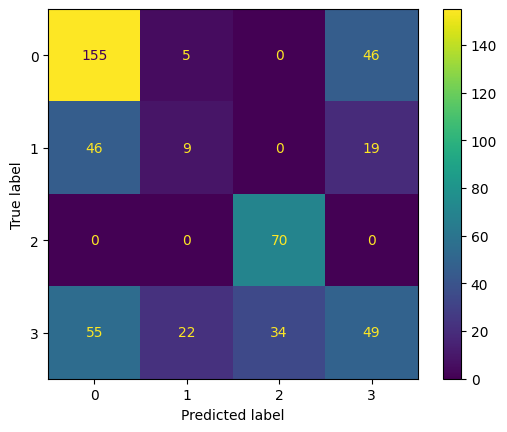

In [26]:
#Confusion matrix using ConfusionMatrixDisplay from sklearn

# predictions = model.predict(X_test)

# cMatrix = confusion_matrix(y_test, predictions, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cMatrix,display_labels=model.classes_)
disp.plot()
plt.show()

**************

    Method 7: Modelling using feature selection based on feature importance values (with get_feature_importances type = "FeatureImportance" (default type)) with class imbalance accounted for

In [13]:
# Get feature importance values from the basic model

feat_importances = model.get_feature_importance(prettified=True)
feat_importances.head(200)

,Feature Id,Importances
0,CCCCC,1.670362
1,TATCG,1.264325
2,AAAAA,1.010483
3,TCGAA,0.934071
4,GACGA,0.781961
...,...,...
195,AGACG,0.153297
196,ACGCA,0.152849
197,TTCAT,0.152206
198,TACTG,0.151827


In [14]:
# Show only feature importances above 0.1

threshold_chosen_features = feat_importances[feat_importances['Importances'] >= 0.1]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0.1 (selected features):", num_chosen_features)

    Feature Id  Importances
0        CCCCC     1.670362
1        TATCG     1.264325
2        AAAAA     1.010483
3        TCGAA     0.934071
4        GACGA     0.781961
..         ...          ...
327      TAAGA     0.101001
328      ATCCG     0.100699
329      CTTGT     0.100629
330      CTGCT     0.100175
331      GGGAA     0.100082

[332 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 332


In [15]:
# Calculate sum of importance values of chosen features 
print("Sum of total feature importances: ", sum(feat_importances.Importances))
print("Sum of feature importances >=0.1: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  99.99999999999976
Sum of feature importances >=0.1:  72.20714290468543


In [16]:
#Get only selected features (i.e. with importance values >= 0.1) from X_train

# selected_feat = feat_importances[:349]['Feature Id'].tolist()
selected_feat = feat_importances[:num_chosen_features]['Feature Id'].tolist()
# print(selected_feat)

In [35]:
X_train.tail()

,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
2035,0.004505,0.001855,0.004240,0.004240,0.001855,0.000928,0.000265,0.002385,0.003843,0.002253,...,0.000265,0.002518,0.002120,0.001723,0.001458,0.002253,0.000928,0.002253,0.002518,0.003710
2036,0.003446,0.003048,0.003711,0.002518,0.003711,0.001060,0.001193,0.002253,0.004506,0.002385,...,0.000265,0.001193,0.000928,0.000398,0.000795,0.000663,0.000398,0.000133,0.000928,0.000398
2037,0.001989,0.001061,0.002519,0.002254,0.000663,0.001458,0.000928,0.001193,0.002254,0.002386,...,0.000133,0.001591,0.001458,0.001193,0.001856,0.000928,0.001458,0.000928,0.001591,0.002386
2038,0.003182,0.001193,0.002254,0.000398,0.001326,0.001591,0.000265,0.001326,0.001856,0.001591,...,0.000265,0.000663,0.001856,0.000928,0.000265,0.000398,0.000530,0.000398,0.000663,0.000398
2039,0.010356,0.003054,0.005709,0.004647,0.003850,0.001328,0.000398,0.002390,0.004780,0.001859,...,0.000266,0.003319,0.001593,0.001593,0.002124,0.003585,0.003850,0.002523,0.001726,0.004780


In [17]:
#Create training set with selected features 

X_train_selected = X_train[selected_feat]
X_train_selected.tail()

,CCCCC,TATCG,AAAAA,TCGAA,GACGA,AGCAG,ACGAA,CGATT,TAACG,CCTGG,...,TGAAG,ATCTC,GCTCG,ACGCG,AAGGC,TAAGA,ATCCG,CTTGT,CTGCT,GGGAA
2035,0.000265,0.000000,0.004505,0.000795,0.000000,0.002253,0.000132,0.000265,0.000000,0.001060,...,0.002783,0.001193,0.000265,0.000132,0.000928,0.001193,0.000132,0.001060,0.001193,0.000663
2036,0.000398,0.000663,0.003446,0.000663,0.000928,0.003578,0.000530,0.000265,0.000000,0.000398,...,0.005433,0.001325,0.000398,0.000000,0.001458,0.001193,0.000530,0.000530,0.001458,0.001325
2037,0.001856,0.000133,0.001989,0.000530,0.000398,0.002519,0.000530,0.000663,0.000398,0.000795,...,0.002651,0.001193,0.000530,0.000133,0.001591,0.000928,0.000133,0.001458,0.001193,0.001193
2038,0.001061,0.000000,0.003182,0.000796,0.000796,0.004773,0.000265,0.000000,0.000000,0.001856,...,0.005569,0.000928,0.000663,0.000133,0.001458,0.001193,0.000133,0.001061,0.003447,0.001591
2039,0.000133,0.000133,0.010356,0.000133,0.000266,0.001726,0.000398,0.000266,0.000000,0.000664,...,0.001195,0.001460,0.000531,0.000000,0.000664,0.002124,0.000133,0.000797,0.001859,0.000797


In [37]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(X_train_selected.columns) == selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [18]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", X_train_selected.shape)
print("Shape of y_train (number of labels):", y_train.shape)


Shape of X_train_selected (number of variables/sequences): (2040, 332)
Shape of y_train (number of labels): (2040,)


In [19]:
# Create new pool object with only selected feature data
print("Original number of features:", len(ALL_feature_names), "\n Number of selected features:", len(selected_feat))

selected_train_pool = Pool(X_train_selected, y_train, feature_names=selected_feat)

Original number of features: 1024 
 Number of selected features: 332


In [20]:
#Create new model for data with selected features
multi_FIFS_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

multi_FIFS_model.fit(selected_train_pool)

Learning rate set to 0.082057
0:	learn: 1.3378021	total: 102ms	remaining: 1m 42s
1:	learn: 1.2970719	total: 193ms	remaining: 1m 36s
2:	learn: 1.2616435	total: 286ms	remaining: 1m 35s
3:	learn: 1.2192190	total: 383ms	remaining: 1m 35s
4:	learn: 1.1804239	total: 488ms	remaining: 1m 37s
5:	learn: 1.1503167	total: 594ms	remaining: 1m 38s
6:	learn: 1.1232393	total: 687ms	remaining: 1m 37s
7:	learn: 1.0977979	total: 784ms	remaining: 1m 37s
8:	learn: 1.0712668	total: 880ms	remaining: 1m 36s
9:	learn: 1.0484343	total: 978ms	remaining: 1m 36s
10:	learn: 1.0268042	total: 1.08s	remaining: 1m 37s
11:	learn: 1.0067842	total: 1.18s	remaining: 1m 36s
12:	learn: 0.9906812	total: 1.26s	remaining: 1m 35s
13:	learn: 0.9708018	total: 1.35s	remaining: 1m 35s
14:	learn: 0.9528535	total: 1.44s	remaining: 1m 34s
15:	learn: 0.9363538	total: 1.53s	remaining: 1m 34s
16:	learn: 0.9211725	total: 1.63s	remaining: 1m 34s
17:	learn: 0.9066772	total: 1.71s	remaining: 1m 33s
18:	learn: 0.8957646	total: 1.79s	remaining:

In [21]:
#Check parameters used in this model fit

multi_FIFS_params = multi_FIFS_model.get_all_params()
print("FIFS model parameters for multiclass classification:", multi_FIFS_params)

FIFS model parameters for multiclass classification: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1, 2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [1, 2.7837836742401123, 2.942857027053833, 1.287500023841858], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees':

In [22]:
#Prediction using X_test only for selected features data
FIFS_y_pred = multi_FIFS_model.predict(X_test)

#Predication probability for selected features data

FIFS_y_prob = multi_FIFS_model.predict_proba(X_test)

In [23]:
# Calculate F1 score and get classification report

print("Model 7: Feature selection (PredictionValuesChange) w/ class imbalance accounted for - Multiclass")

print("Number of chosen features:", num_chosen_features, "\n")

FIFS_cr = classification_report(y_test, FIFS_y_pred, digits=3)
print(FIFS_cr)

print('Accuracy score: ', accuracy_score(y_test, FIFS_y_pred))
print('ROC AUC score : ', roc_auc_score(y_test, FIFS_y_prob, multi_class='ovr'))

FIFS_f1 = f1_score(y_test, FIFS_y_pred, average='macro')
print(f"\nF1 Score: {FIFS_f1}")

Model 7: Feature selection (PredictionValuesChange) w/ class imbalance accounted for - Multiclass
Number of chosen features: 332 

              precision    recall  f1-score   support

           0      0.616     0.723     0.665       206
           1      0.224     0.149     0.179        74
           2      0.680     0.971     0.800        70
           3      0.462     0.344     0.394       160

    accuracy                          0.555       510
   macro avg      0.496     0.547     0.510       510
weighted avg      0.520     0.555     0.528       510

Accuracy score:  0.5549019607843138
ROC AUC score :  0.7603496896724828

F1 Score: 0.509576398255342


In [27]:
# Confusion matrix for selected data

print("real values shape:", y_test.shape)
print("prediction shape:", FIFS_y_pred.shape)

FIFS_y_pred_fl = FIFS_y_pred
print("flattened prediction values shape:", FIFS_y_pred_fl.ravel().shape, "\n")

FIFS_cMatrix = confusion_matrix(y_test, FIFS_y_pred_fl)
print(FIFS_cMatrix)

real values shape: (510,)
prediction shape: (510, 1)
flattened prediction values shape: (510,) 

[[149  14   0  43]
 [ 42  11   0  21]
 [  0   2  68   0]
 [ 51  22  32  55]]


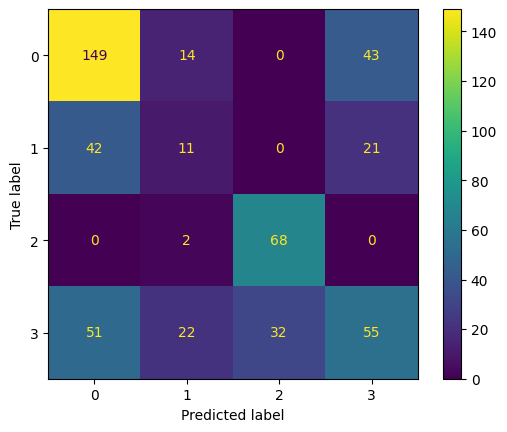

In [28]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=FIFS_cMatrix, display_labels=multi_FIFS_model.classes_)
disp.plot()
plt.show()

*************

    Method 3: Modelling using feature selection based on feature importance values (SHAP Values)

In [50]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(model)

In [51]:
#SHAP values for X_train
multi_shap_values = explainer.shap_values(X_train)

In [55]:
multi_shap_values[0].shape

(2040, 1024)

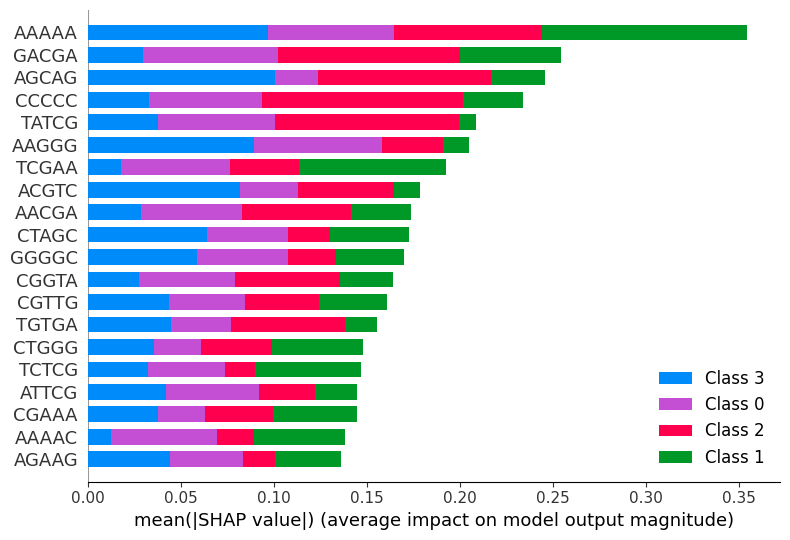

In [60]:
shap.summary_plot(multi_shap_values, X_train, plot_size=0.2, class_names = ["Class 0", "Class 1", "Class 2", "Class 3"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


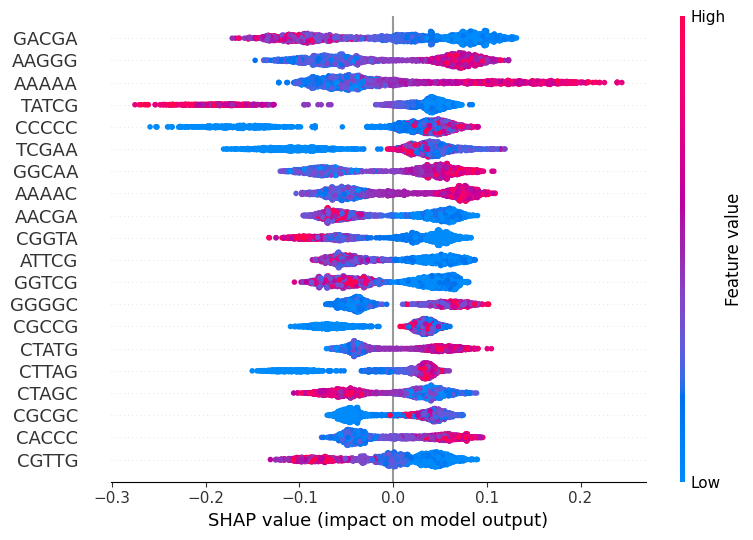

In [53]:
# Summary shap bar plot of Cytoplasm class (class 0)
shap.summary_plot(multi_shap_values[0], X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


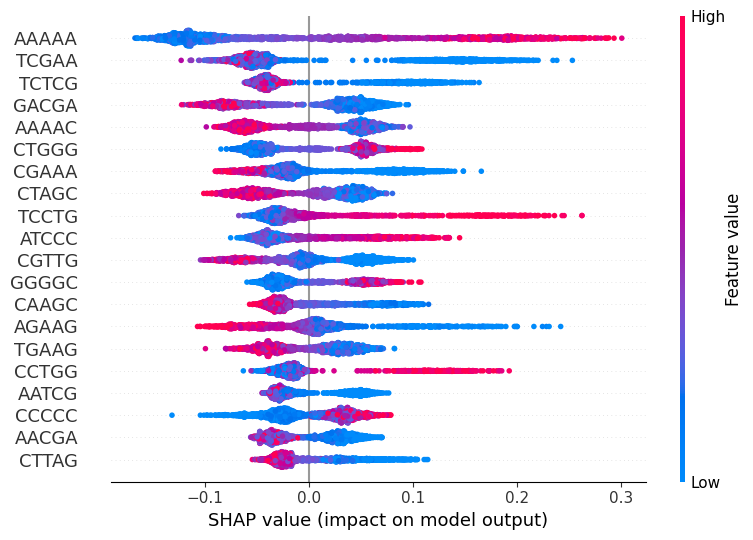

In [61]:
# Summary shap bar plot of Endoplasmic reticuum class (class 1)
shap.summary_plot(multi_shap_values[1], X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


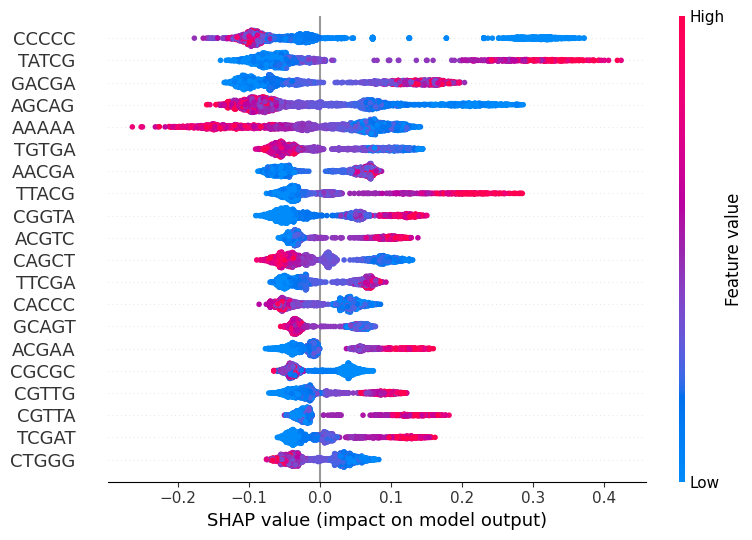

In [62]:
# Summary shap bar plot of mitochondria class (class 2)
shap.summary_plot(multi_shap_values[2], X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


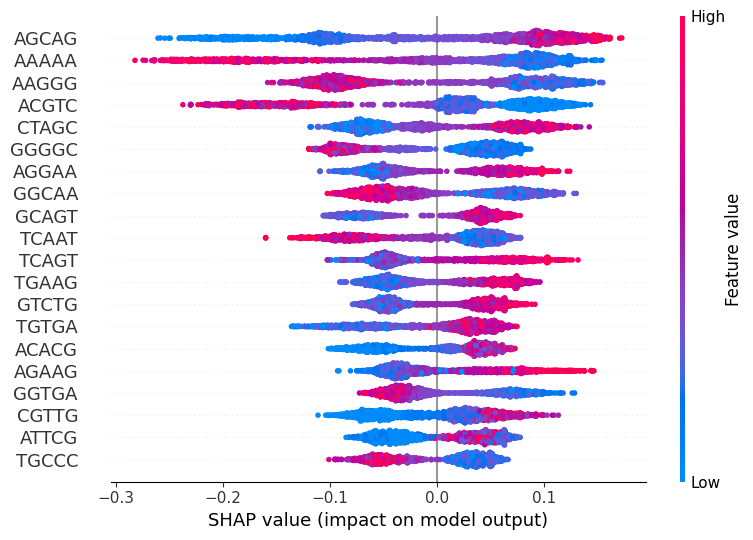

In [63]:
# Summary shap bar plot of nucleus class (class 3)
shap.summary_plot(multi_shap_values[3], X_train, plot_size=0.2)

In [79]:
#Put values one one class into dataframe to use as reference values for FS
shap_df = pd.DataFrame(multi_shap_values[3], columns=X_train.columns)


In [80]:
# Calculate feature importance by only taking the values which 
multi_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [81]:
multi_shap_FI.head(10)

,Feature Id,Importances
0,AGCAG,0.090256
1,AAGGG,0.087149
2,AAAAA,0.078415
3,CTAGC,0.076747
4,GGCAA,0.070394
5,GGTGA,0.066742
6,TGGCT,0.066131
7,AGGAA,0.063413
8,AGAAG,0.061055
9,TCAGT,0.060503


In [ ]:
#Classifier results with CE_feature_importance

In [83]:
from numpy import nansum
print("Sum of all shap feature importance values of class 3:", nansum(multi_shap_FI["Importances"]))

Sum of all shap feature importance values of class 3: 8.339814995491324


In [84]:
# Show only class 3 feature importances above 0.005 (0.01/2 = 0.005)

multi_SHAP_thres_chosen = multi_shap_FI[multi_shap_FI['Importances'] >= 0.005]
multi_shap_num_chosen = len(multi_SHAP_thres_chosen)

print(multi_SHAP_thres_chosen)

print("\nAmount of features in class 3 with importance above 0.005 (selected features):", multi_shap_num_chosen)

    Feature Id  Importances
0        AGCAG     0.090256
1        AAGGG     0.087149
2        AAAAA     0.078415
3        CTAGC     0.076747
4        GGCAA     0.070394
..         ...          ...
488      CACGT     0.005029
489      ATGTC     0.005015
490      GGGGG     0.005007
491      GTACA     0.005006
492      GTGCT     0.005003

[493 rows x 2 columns]

Amount of features in class 3 with importance above 0.005 (selected features): 493


In [85]:
print("Sum of total feature importances: ", sum(multi_shap_FI.Importances))
print("Sum of feature importances >=0.005: ", sum(multi_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances >=0.005:  6.963035405219086


In [87]:
# Select features with importance values above 0.005

multi_shap_selected_feat = multi_shap_FI[:multi_shap_num_chosen]['Feature Id'].tolist()

# print(multi_shap_selected_feat)

In [89]:
# See original training set

X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
824,0.004569,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003126,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003126,0.001924,0.001203,0.002405,0.001443


In [90]:
#Create training set with selected features 

multi_X_train_shap_selected = X_train[multi_shap_selected_feat]
multi_X_train_shap_selected.head()

,AGCAG,AAGGG,AAAAA,CTAGC,GGCAA,GGTGA,TGGCT,AGGAA,AGAAG,TCAGT,...,GAGAG,TACAA,AGGTT,AGCGC,TATTC,CACGT,ATGTC,GGGGG,GTACA,GTGCT
0,0.002059,0.001267,0.003643,0.000634,0.001426,0.001109,0.001109,0.001742,0.001742,0.001109,...,0.001901,0.000634,0.000634,0.001109,0.000950,0.000317,0.000792,0.000317,0.001267,0.001267
1,0.003788,0.001748,0.002914,0.000583,0.001457,0.001166,0.002331,0.002040,0.004079,0.002040,...,0.002331,0.000583,0.000583,0.001748,0.000000,0.000291,0.000874,0.004371,0.000874,0.001166
2,0.002291,0.002750,0.002291,0.000000,0.000917,0.001375,0.003666,0.001833,0.002291,0.000458,...,0.002291,0.000917,0.000458,0.000458,0.000917,0.000000,0.001375,0.002750,0.000917,0.000917
3,0.003464,0.003464,0.000000,0.000495,0.001484,0.000990,0.000495,0.000495,0.000990,0.001484,...,0.001484,0.000495,0.000000,0.000495,0.000000,0.000000,0.000495,0.002474,0.000000,0.001484
4,0.001762,0.001037,0.013061,0.000311,0.001140,0.001037,0.001659,0.002488,0.001659,0.001555,...,0.001866,0.001348,0.001140,0.000104,0.001348,0.000000,0.000622,0.000518,0.000829,0.001348


In [91]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(multi_X_train_shap_selected.columns) == multi_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [92]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", multi_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", y_train.shape)

Shape of X_train_selected (number of variables/sequences): (2040, 493)
Shape of y_train (number of labels): (2040,)


In [93]:
# Create pool object for selected feature data
print("Original number of features:", len(ALL_feature_names), "\n Number of selected features:", len(multi_shap_selected_feat))

multi_shap_selected_train_pool = Pool(multi_X_train_shap_selected, y_train, feature_names=multi_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 493


In [94]:
#Create new model for data with selected features
multi_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

multi_FIFS_shap_model.fit(multi_shap_selected_train_pool)

Learning rate set to 0.082057
0:	learn: 1.3312817	total: 292ms	remaining: 4m 51s
1:	learn: 1.2831730	total: 470ms	remaining: 3m 54s
2:	learn: 1.2428177	total: 663ms	remaining: 3m 40s
3:	learn: 1.2041017	total: 834ms	remaining: 3m 27s
4:	learn: 1.1733725	total: 978ms	remaining: 3m 14s
5:	learn: 1.1436819	total: 1.1s	remaining: 3m 2s
6:	learn: 1.1173999	total: 1.24s	remaining: 2m 56s
7:	learn: 1.0930065	total: 1.37s	remaining: 2m 50s
8:	learn: 1.0694532	total: 1.51s	remaining: 2m 45s
9:	learn: 1.0471435	total: 1.63s	remaining: 2m 41s
10:	learn: 1.0291716	total: 1.79s	remaining: 2m 40s
11:	learn: 1.0102205	total: 1.92s	remaining: 2m 37s
12:	learn: 0.9937675	total: 2.06s	remaining: 2m 36s
13:	learn: 0.9771773	total: 2.19s	remaining: 2m 34s
14:	learn: 0.9638367	total: 2.33s	remaining: 2m 32s
15:	learn: 0.9499410	total: 2.46s	remaining: 2m 31s
16:	learn: 0.9341625	total: 2.58s	remaining: 2m 29s
17:	learn: 0.9209019	total: 2.72s	remaining: 2m 28s
18:	learn: 0.9068292	total: 2.85s	remaining: 2

In [95]:
#Check parameters used in this model fit

multi_FIFS_shap_params = multi_FIFS_shap_model.get_all_params()
print("Basic model parameters:", multi_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1, 2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.082056999206

In [96]:
#Prediction using X_test only for selected features data
multi_FIFS_shap_y_pred = multi_FIFS_shap_model.predict(X_test)

#Predication probability for selected features data

multi_FIFS_shap_y_prob = multi_FIFS_shap_model.predict_proba(X_test)

In [98]:
# Calculate F1 score and get classification report

print("Model 3: Feature selection (SHAP) - Multiclass")

print("Number of chosen features:", len(multi_shap_selected_feat), "\n")

multi_FIFS_shap_cr = classification_report(y_test, multi_FIFS_shap_y_pred, digits=3)
print(multi_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(y_test, multi_FIFS_shap_y_pred))

multi_FIFS_shap_f1 = f1_score(y_test, multi_FIFS_shap_y_pred, average='macro')
print('ROC AUC score : ', roc_auc_score(y_test, FIFS_y_prob, multi_class='ovr'))
print(f"\nF1 Score: {multi_FIFS_shap_f1}")


Model 3: Feature selection (SHAP) - Multiclass
Number of chosen features: 493 

              precision    recall  f1-score   support

           0      0.570     0.791     0.663       206
           1      0.304     0.095     0.144        74
           2      0.680     0.971     0.800        70
           3      0.406     0.256     0.314       160

    accuracy                          0.547       510
   macro avg      0.490     0.528     0.480       510
weighted avg      0.495     0.547     0.497       510

Accuracy score:  0.5470588235294118
ROC AUC score :  0.7317894134820837

F1 Score: 0.48027694203355115


In [100]:
# Confusion matrix for selected data

print("real values shape:", y_test.shape)
print("prediction shape:", multi_FIFS_shap_y_pred.shape)

multi_FIFS_shap_y_pred_fl = multi_FIFS_shap_y_pred
print("flattened prediction values shape:", multi_FIFS_shap_y_pred_fl.ravel().shape, "\n")

multi_FIFS_shap_cMatrix = confusion_matrix(y_test, multi_FIFS_shap_y_pred_fl)
print(multi_FIFS_shap_cMatrix)

real values shape: (510,)
prediction shape: (510, 1)
flattened prediction values shape: (510,) 

[[163   1   0  42]
 [ 49   7   0  18]
 [  0   2  68   0]
 [ 74  13  32  41]]


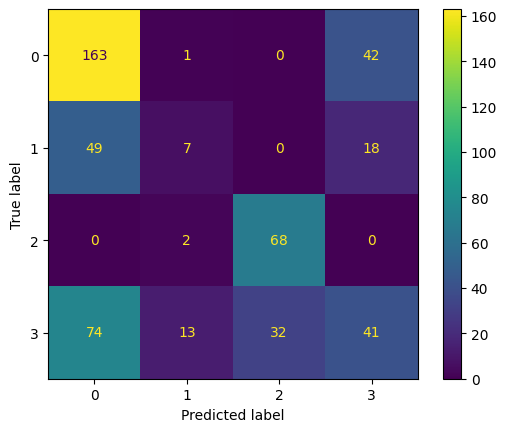

In [102]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=multi_FIFS_shap_cMatrix, display_labels=multi_FIFS_shap_model.classes_)
disp.plot()
plt.show()